##### Copyright 2018 The TensorFlow Authors.

## Setup

In [41]:
import numpy as np


import tensorflow as tf

import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import pandas as pd
import re   
import string
from sklearn.model_selection import train_test_split
import keras_nlp
import keras_tuner

from tensorflow import keras
from keras.utils import to_categorical
tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
# ## Method for getting input
# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# from nltk.corpus import stopwords
# import nltk
# nltk.download("punkt")
# nltk.download('wordnet')
# nltk.download("stopwords")

# def parse_text(text):

#     ## Tokenize string into words (and punctuation)
#     word_array = word_tokenize(text)
#     word_array = [word.lower() for word in word_array if word.isalpha()]

#     ## Filter out stop words
#     stop_words = set(stopwords.words("english"))
#     filtered_words = [word for word in word_array if word.casefold() not in stop_words]

#     ## Turn words into lemmatized words
#     lemmatizer = WordNetLemmatizer()
#     lemitized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

#     ## Apply Stemming (Find the roots of similar words)
#     stemmer = PorterStemmer()
#     stemmed_words = [stemmer.stem(word) for word in lemitized_words]

#     joined_words = ""
#     #for word in stemmed_words:
#     joined_words = " ".join(list(stemmed_words))
#     return joined_words

In [ ]:
###makes clean file

# import csv
# csv.field_size_limit(10000000)
# text_list = []
# with open("master_dataset.csv", newline='') as f:
#     #reader = csv.reader(f)
#     data = list(csv.reader(f))
# #print(data[:10])
# for row in data:
    
#     #print(parse_text(row[2]))
#     text_list.append(str(parse_text(row[2])))

# #print(text_list[:10])
# with open("master_dataset_clean.csv", 'w') as f2:
#     #writer = csv.writer(f2)
#     for x in text_list:
#         f2.write(x)
#         f2.write('\n')
        #writer.writerows([row])
            

In [20]:
tickets = pd.read_csv("master_dataset_clean.csv", skip_blank_lines = False, keep_default_na=False)
tickets = tickets.fillna('[UNK]')
tickets2 = pd.read_csv("labelled_dataset.csv")
tickets3 = pd.DataFrame()

#print(tickets['desc'][:3])
#tickets['desc'] = [parse_text(text) for text in tickets['desc']]
#tickets['desc'] = tickets['desc'].apply(parse_text())
#print(tickets['desc'][:3])

text_column = tickets['desc']
tickets3 = pd.concat([tickets3,text_column], axis = 1)
label_column = tickets2['Grade'].astype(int)
label_column = label_column - 1
tickets3 = pd.concat([tickets3,label_column], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(text_column, label_column, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)
y_val_cat = to_categorical(y_val, 3)


X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
X_val_dataset = tf.data.Dataset.from_tensor_slices(X_val)
# y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
# y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train_cat)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test_cat)
y_val_dataset = tf.data.Dataset.from_tensor_slices(y_val_cat)

test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset))
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset))
val_dataset = tf.data.Dataset.zip((X_val_dataset, y_val_dataset))

# print(train_dataset.element_spec)
# print(test_dataset.element_spec)

In [ ]:
np.array(train_dataset)

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [13]:
BUFFER_SIZE = 10000 #10000
BATCH_SIZE = 128 #64
VOCAB_SIZE = 2500 #1000

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 2500 #1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

## Create the model

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [ ]:
# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder.get_vocabulary()),
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     #tf.keras.layers.Dense(1)
#     tf.keras.layers.Dense(3, activation='softmax')
# ])


model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    #keras_nlp.layers.FNetEncoder(intermediate_dim=64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])



Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

Compile the Keras model to configure the training process:

In [ ]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    #optimizer=tf.keras.optimizers.SGD(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"] #tf.keras.metrics.CategoricalAccuracy()
)

In [ ]:
model.summary()

## Train the model

In [ ]:
#find weights for labels

samp0 = 54046
samp1 = 24077
samp2 = 9863
tot_samples = samp0 + samp1 + samp2

w0 = tot_samples / (3*samp0)
w1 = tot_samples / (3*samp1)
w2 = tot_samples / (3*samp2)

In [ ]:
history = model.fit(train_dataset, 
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    #class_weight = {0:w0,1:w1,2:w2},
                    #use_multiprocessing = True,
                    #workers = 5
                    )
#class weight has made it worse

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

print(np.argsmax(predictions[0]))

## Model 2

In [21]:
train_dataset1 = train_dataset.shuffle(BUFFER_SIZE).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset1 = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset1 = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



VOCAB_SIZE = 2500 #1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset1.map(lambda text, label: text))


# train_dataset2 = train_dataset.shuffle(512).prefetch(16).cache()
# test_dataset2 = test_dataset.shuffle(512).prefetch(16).cache()

2023-07-21 19:28:40.857703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [63349]
	 [[{{node Placeholder/_0}}]]
2023-07-21 19:28:40.857948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [63349]
	 [[{{node Placeholder/_0}}]]


In [22]:
# model2 = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     keras_nlp.layers.FNetEncoder(intermediate_dim=128),
#     keras_nlp.layers.FNetEncoder(intermediate_dim=128),
#     keras_nlp.layers.FNetEncoder(intermediate_dim=128),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 8, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4)),
    keras_nlp.layers.FNetEncoder(intermediate_dim=8),
    keras_nlp.layers.FNetEncoder(intermediate_dim=8),
    keras_nlp.layers.FNetEncoder(intermediate_dim=8),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax')
])
# input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")
# x = encoder((input_ids))
# # x = keras_nlp.layers.TokenAndPositionEmbedding(
# #     vocabulary_size=VOCAB_SIZE,
# #     sequence_length=512,
# #     embedding_dim=128,
# #     mask_zero=True,
# # )(input_ids)

# x = keras_nlp.layers.FNetEncoder(intermediate_dim=128)(inputs=x)
# x = keras_nlp.layers.FNetEncoder(intermediate_dim=128)(inputs=x)
# x = keras_nlp.layers.FNetEncoder(intermediate_dim=128)(inputs=x)


# x = keras.layers.GlobalAveragePooling1D()(x)
# x = keras.layers.Dropout(0.1)(x)
# outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

# fnet_classifier = keras.Model(input_ids, outputs, name="fnet_classifier")



model2.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    #optimizer=tf.keras.optimizers.SGD(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"] #tf.keras.metrics.CategoricalAccuracy()
)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 8)           20000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 8)                416       
 nal)                                                            
                                                                 
 f_net_encoder_3 (FNetEncode  (None, 8)                176       
 r)                                                              
                                                                 
 f_net_encoder_4 (FNetEncode  (None, 8)                176       
 r)                                                   

In [23]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(X_test)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

print(steps_per_epoch)


549


In [16]:
history2 = model2.fit(train_dataset1, 
                    epochs=100,
                    validation_data=val_dataset1,
                    validation_steps=30,
                    steps_per_epoch=steps_per_epoch
                    #class_weight = {0:w0,1:w1,2:w2},
                    #use_multiprocessing = True,
                    #workers = 5
                    )

Epoch 1/3


2023-07-21 19:00:18.899569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [70388]
	 [[{{node Placeholder/_0}}]]
2023-07-21 19:00:18.899839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [70388,3]
	 [[{{node Placeholder/_2}}]]


2023-07-21 19:00:21.217646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


2023-07-21 19:00:24.686806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-21 19:00:25.670534: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	w

 884/2200 [===========>..................] - ETA: 5:47 - loss: 1.1196 - accuracy: 0.4625

KeyboardInterrupt: 

In [11]:
test_loss, test_acc = model2.evaluate(test_dataset1)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

138/138 [==============================] - 27s 195ms/step - loss: 1.0181 - accuracy: 0.5425
Test Loss: 1.0181047916412354
Test Accuracy: 0.5425048470497131


In [13]:
model2.evaluate(test_dataset1, batch_size=BATCH_SIZE)


  1/138 [..............................] - ETA: 5s - loss: 1.0176 - accuracy: 0.5469

138/138 [==============================] - 27s 196ms/step - loss: 1.0181 - accuracy: 0.5425


[1.0181047916412354, 0.5425048470497131]

(0.0, 1.1905199944972993)

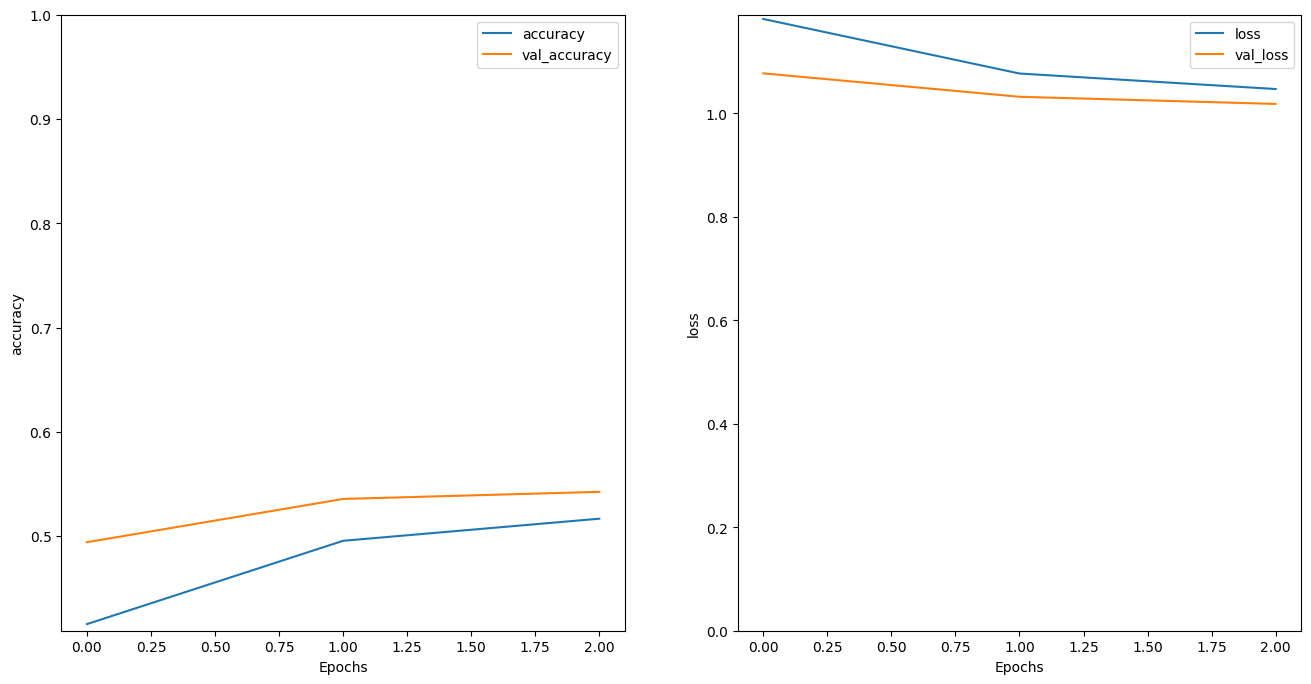

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')
plt.ylim(0, None)

In [17]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(X_test)
steps_per_epoch = int(train_data_size / BATCH_SIZE)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

print(steps_per_epoch)


137


In [10]:
#save model
!mkdir -p saved_model
model2.save('saved_model/FNetEncoder_Model.h5')


NameError: name 'model2' is not defined

In [31]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('saved_model/FNetEncoder_Model.h5')

# Show the model architecture
new_model.summary()



OSError: No file or directory found at saved_model/FNetEncoder_Model.h5

In [ ]:
train_dataset2 = train_dataset.shuffle(BUFFER_SIZE).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset2 = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset2 = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



VOCAB_SIZE = 2500 #1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset2.map(lambda text, label: text))

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
input_shape = (X_train.shape[0],None,3)

In [45]:

def hyper_class(hp):
    model = keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(len(encoder.get_vocabulary()), output_dim=hp.Int("output_dim", min_value=8, max_value=128, step=32), mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4)),
        keras_nlp.layers.FNetEncoder(intermediate_dim=hp.Int("intermediate_dim1", min_value=8, max_value=128, step=32),
                                    dropout=hp.Float("dropout1", 0.1, 0.8, sampling="log")),
        keras_nlp.layers.FNetEncoder(intermediate_dim=hp.Int("intermediate_dim2", min_value=8, max_value=128, step=32),
                                    dropout=hp.Float("dropout2", 0.1, 0.8, sampling="log")),
        keras_nlp.layers.FNetEncoder(intermediate_dim=hp.Int("intermediate_dim3", min_value=8, max_value=128, step=32),
                                    dropout=hp.Float("dropout3", 0.1, 0.8, sampling="log")),
        tf.keras.layers.Dropout(rate=hp.Float("rate", 0.1, 0.99, sampling="log")),
        tf.keras.layers.Dense(3, activation='softmax'),
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")), 
        loss="categorical_crossentropy", 
        metrics=["accuracy","crossentropy"],
    )
    return model



tuner = keras_tuner.Hyperband(
    hypermodel=hyper_class,
    # Objective is one of the keys.
    # Maximize the negative MAE, equivalent to minimize MAE.
    objective=['val_accuracy', 'val_crossentropy'],
    max_epochs=20,
    directory="saved_model",
    project_name="classif_hypertuning",
)

tuner.search(x=X_train[:1000], y=y_train_cat[:1000], validation_data=(X_val[:1000], y_val_cat[:1000]), callbacks = [callback])
best_model = tuner.get_best_models()[0]

Trial 26 Complete [00h 03m 05s]
multi_objective: 0.4712008237838745

Best multi_objective So Far: 0.40578633546829224
Total elapsed time: 00h 41m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

In [ ]:
tuner.results_summary()


In [30]:
print(train_dataset.cardinality().numpy())
for element in train_dataset:
    print(element)
    break

63349
(<tf.Tensor: shape=(), dtype=string, numpy=b'build setup instal last time modul instal novemb modul need tri build python api separ'>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)


2023-07-21 20:00:35.075349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [63349,3]
	 [[{{node Placeholder/_2}}]]
